Loaded 38 weekly observations from 2009-04-12 to 2009-12-27
Starting optimization (this may take time)...
Optimization finished. Result x_opt: [ 0.3  0.4  0.  52. ]
R^2 = -1.7091


C:\Users\Hannah\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


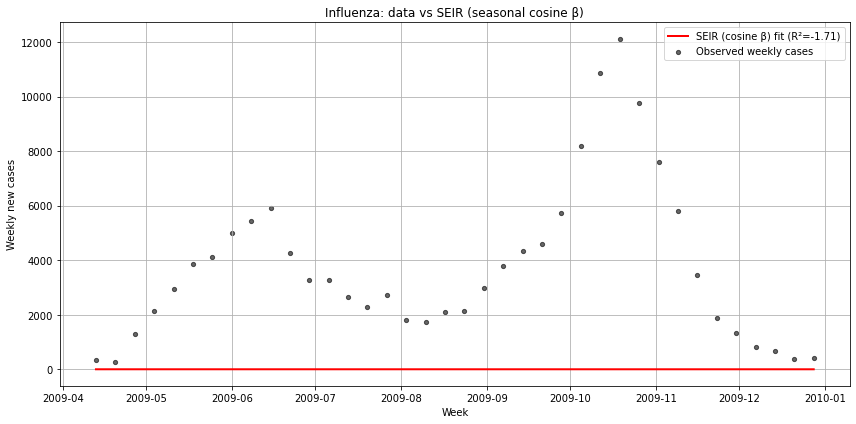

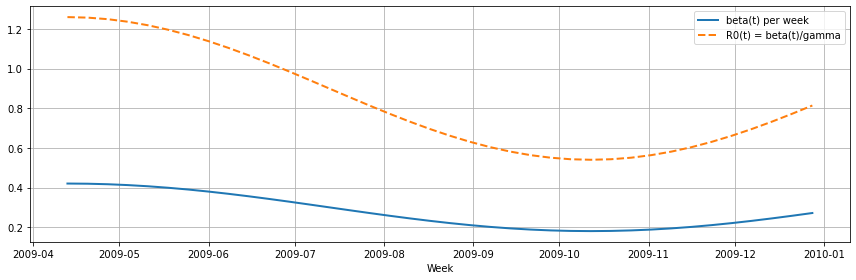

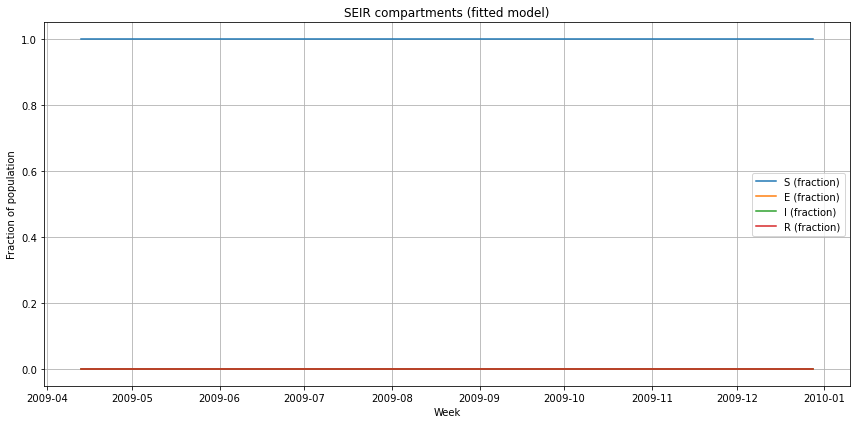

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

filename = 'BzKTarPx(1) - Kopie.csv'  #  file
date_col = 'ISO_SDATE'   # column with a date for each week 
cases_col = 'INF_ALL'  # column with weekly new registered influenza cases
population = 305000000     #  population of the region 
# initial infectious (rough guess).
I0_guess = 1.0

gamma_per_week = (1.0/3.0)    # default: infectious period ≈ 3 days 
sigma_per_week = (1.0/1.5)    # default: incubation ≈ 1.5 days 

dt = 1.0  # one time step = one week

# -------------------------
# Load data
# -------------------------
df = pd.read_csv(filename)

#df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
# parse ISO 8601 timestamps
df[date_col] = pd.to_datetime(df[date_col])

# keep only the needed columns
df = df[[date_col, cases_col]]

df = df.sort_values(date_col).reset_index(drop=True)

observed = np.maximum(df[cases_col].values.astype(float), 0.0)
n_weeks = len(observed)
weeks = np.arange(n_weeks)
print(f"Loaded {n_weeks} weekly observations from {df[date_col].iloc[0].date()} to {df[date_col].iloc[-1].date()}")

# SEIR with cosine seasonal beta

N = float(population)
gamma = float(gamma_per_week)
sigma = float(sigma_per_week)

def run_seir_cosine(params, n_steps, I0=I0_guess):
    """
    params = [beta0, A, phi] or [beta0, A, phi, T]
      - beta0: baseline beta (per week)
      - A: relative amplitude (0 <= A < 1 recommended)
      - phi: phase shift in weeks (0..T)
      - T: period in weeks (optional). default 52
    returns:
      - weekly_new_cases: array of length n_steps (sigma * E * dt)
      - betas: beta(t) per week
      - compartments: tuple (S, E, I, R) arrays
    """
    if len(params) == 4:
        beta0, A, phi, T = params
    else:
        beta0, A, phi = params
        T = 52.0

    t = np.arange(n_steps)
    betas = beta0 * (1.0 + A * np.cos(2.0 * np.pi * (t - phi) / T))
    betas = np.maximum(betas, 1e-9)  

    S = np.zeros(n_steps+1)
    E = np.zeros(n_steps+1)
    I = np.zeros(n_steps+1)
    R = np.zeros(n_steps+1)

    # initial conditions
    S[0] = N - I0
    E[0] = 0.0
    I[0] = I0
    R[0] = 0.0

    weekly_new = np.zeros(n_steps)

    for tt in range(n_steps):
        beta = betas[tt]

        # new infections this week 
        new_inf = (beta * S[tt] * I[tt] / N) * dt

        # discrete update (explicit Euler)
        S[tt+1] = S[tt] - new_inf
        E[tt+1] = E[tt] + new_inf - sigma * E[tt] * dt
        I[tt+1] = I[tt] + sigma * E[tt] * dt - gamma * I[tt] * dt
        R[tt+1] = R[tt] + gamma * I[tt] * dt

        weekly_new[tt] = sigma * E[tt] * dt  # people exiting incubation this week

        # ensure non-negativity (numerical stability)
        S[tt+1] = max(S[tt+1], 0.0)
        E[tt+1] = max(E[tt+1], 0.0)
        I[tt+1] = max(I[tt+1], 0.0)
        R[tt+1] = max(R[tt+1], 0.0)

    # return compartments trimmed to length n_steps (time aligned)
    return weekly_new, betas, (S[:-1], E[:-1], I[:-1], R[:-1])


def mse_objective(x, observed):
    preds, _, _ = run_seir_cosine(x, len(observed))
    return np.mean((observed - preds)**2)


beta0_0 = 0.3   # initial guess (per week)
A_0 = 0.4       # 40% seasonal swing
phi_0 = 0.0     # guess phase (weeks relative to first data point)
T_fixed = 52.0

x0 = np.array([beta0_0, A_0, phi_0, T_fixed])

# bounds: (beta0, A, phi, T)
bounds = [
    (1e-4, 5.0),    # beta0: avoid zero, upper bound reasonably large
    (0.0, 0.99),    # A: amplitude (restrict <1 to keep beta positive)
    (0.0, 52.0),    # phi: within a year
    (52.0, 52.0)    # fix T to 52 weeks; if you want to fit T, change bounds
]

# Convert bounds to format for fmin_l_bfgs_b: list of tuples
# If you force T fixed, fmin will not move it but keep value in x vector.
print("Starting optimization (this may take time)...")
x_opt, f_min, info = fmin_l_bfgs_b(
    func=mse_objective,
    x0=x0,
    args=(observed,),
    bounds=bounds,
    approx_grad=True,
    maxfun=80000,
    factr=1e7,   # loosen / tighten to control precision (lower => tighter)
    disp=1
)

print("Optimization finished. Result x_opt:", x_opt)
preds_opt, betas_opt, (S, E, I, R) = run_seir_cosine(x_opt, n_weeks)


ss_res = np.sum((observed - preds_opt)**2)
ss_tot = np.sum((observed - np.mean(observed))**2)
r2 = 1.0 - ss_res / ss_tot
print(f"R^2 = {r2:.4f}")


dates = df[date_col]

plt.figure(figsize=(12,6))
plt.scatter(dates, observed, color='black', s=18, alpha=0.6, label='Observed weekly cases')
plt.plot(dates, preds_opt, color='red', lw=2, label=f'SEIR (cosine β) fit (R²={r2:.2f})')
plt.xlabel('Week')
plt.ylabel('Weekly new cases')
plt.title('Influenza: data vs SEIR (seasonal cosine β)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot beta(t) and R0(t)
R_t = betas_opt / gamma
plt.figure(figsize=(12,4))
plt.plot(dates, betas_opt, lw=2, label='beta(t) per week')
plt.plot(dates, R_t, lw=2, linestyle='--', label='R0(t) = beta(t)/gamma')
plt.xlabel('Week')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot compartments (S,E,I,R)
plt.figure(figsize=(12,6))
plt.plot(dates, S / N, label='S (fraction)')
plt.plot(dates, E / N, label='E (fraction)')
plt.plot(dates, I / N, label='I (fraction)')
plt.plot(dates, R / N, label='R (fraction)')
plt.xlabel('Week')
plt.ylabel('Fraction of population')
plt.title('SEIR compartments (fitted model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save outputs if desired
df_out = df.copy()
df_out['pred_weekly'] = preds_opt
df_out['beta_fitted'] = betas_opt
#df_out.to_csv('influenza_fit_results.csv', index=False)
#print("Saved results to influenza_fit_results.csv")

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ------------------------------
# Load your data
# ------------------------------
# Example: CSV file with columns: 'week' and 'cases'
data = pd.read_csv("2009-2012US.csv")
weeks = data['ISO_WEEK'].values          # week numbers
cases_data = data['INF_ALL'].values    # weekly new cases

# ------------------------------
# Model parameters
# ------------------------------
N = 305_000_000   # US population
alpha = 1/3       # recovery rate (infectious period 3 days)

# ------------------------------
# Define the SIR model with seasonal beta
# ------------------------------
def beta(t, beta0, beta1):
    return beta0 + beta1 * np.cos(np.pi * t / 180)

def SIR(y, t, beta0, beta1, alpha):
    S, I = y
    dSdt = -beta(t, beta0, beta1) * S * I / N
    dIdt = beta(t, beta0, beta1) * S * I / N - alpha * I
    return [dSdt, dIdt]

# ------------------------------
# Integrate the SIR model
# ------------------------------
def integrate_SIR(beta0, beta1, t0):
    I0 = 1          # initial infected
    S0 = N - I0
    y0 = [S0, I0]
    
    # Shift weeks by t0
    t = weeks - t0
    
    # Integrate ODE
    sol = odeint(SIR, y0, t, args=(beta0, beta1, alpha))
    S, I = sol.T
    return I

# ------------------------------
# Objective function for fitting
# ------------------------------
def objective(params):
    beta0, beta1, t0 = params
    I_model = integrate_SIR(beta0, beta1, t0)
    # We can compare model to weekly new cases
    return np.sum((I_model - cases_data)**2)

# ------------------------------
# Fit the model
# ------------------------------
bounds = [(0.92*alpha, 2.52*alpha), (0.05*alpha, 0.8*alpha), (-8, 10)]
initial_guess = [1.5, 0.5, 0]  # start near published values

result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

beta0_fit, beta1_fit, t0_fit = result.x
print(f"Fitted parameters: beta0={beta0_fit:.3f}, beta1={beta1_fit:.3f}, t0={t0_fit:.2f}")

I_fit = integrate_SIR(beta0_fit, beta1_fit, t0_fit)

plt.figure(figsize=(10,6))
plt.plot(weeks, cases_data, 'o', label='Data')
plt.plot(weeks, I_fit, '-', label='SIR Model Fit')
plt.xlabel("Week of 2009")
plt.ylabel("Number of Infectious Individuals")
plt.legend()
plt.title("Seasonally Forced SIR Model Fit to Influenza Data")
plt.show()